In [1]:
try:
    import einops
except:
    !pip install -q einops
    !pip install -q vit_pytorch
    !mkdir lenses
    !tar -zxf /kaggle/input/multiclass-classification/lenses.tgz

**Specific Test V. Exploring Transformers**

**Task:** Use a vision transformer method of your choice to build a robust and efficient model for binary classification or unsupervised anomaly detection on the provided dataset. In the case of unsupervised anomaly detection, train your model to learn the distribution of the provided strong lensing images with no substructure. Please implement your approach in PyTorch or Keras and discuss your strategy.


**Dataset Description:** A set of simulated strong gravitational lensing images with and without substructure.

**Evaluation Metrics:** ROC curve (Receiver Operating Characteristic curve) and AUC score (Area Under the ROC Curve)


In [2]:
import copy
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

from itertools import cycle
from PIL import Image
from skimage import io, transform
from sklearn.metrics import auc, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve
from torch import optim
from torch.utils.data import DataLoader, Dataset, SubsetRandomSampler
from torchvision import transforms, utils
from torchvision.transforms import (Compose, Pad, RandomRotation, Resize,
                                    ToTensor)

from tqdm import tqdm

warnings.filterwarnings('ignore')

# Data Preparation

In [3]:
def get_train_valid_loader(
    data_dir,
    batch_size,
    random_seed,
    valid_size=0.1,
    shuffle=True,
    num_workers=2,
    pin_memory=False,
):

    valid_transform = transforms.Compose(
        [
            transforms.RandomCrop(128),
            transforms.Grayscale(num_output_channels=1),
            transforms.ToTensor(),
        ]
    )

    train_transform = transforms.Compose(
        [
            transforms.RandomRotation(30),
            transforms.RandomCrop(128),
            transforms.Resize(256),
            transforms.RandomRotation(180),
            transforms.ColorJitter(brightness=(0.8, 1.2)),
            transforms.Resize(128),
            transforms.Grayscale(num_output_channels=1),
            transforms.ToTensor(),
        ]
    )

    # load the dataset
    train_dataset = datasets.ImageFolder(
        root=data_dir,
        transform=train_transform,
    )

    valid_dataset = datasets.ImageFolder(
        root=data_dir,
        transform=valid_transform,
    )

    num_train = len(train_dataset)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))

    if shuffle:
        np.random.seed(random_seed)
        np.random.shuffle(indices)

    train_idx, valid_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=batch_size,
        sampler=train_sampler,
        num_workers=num_workers,
        pin_memory=pin_memory,
    )
    valid_loader = torch.utils.data.DataLoader(
        valid_dataset,
        batch_size=batch_size,
        sampler=valid_sampler,
        num_workers=num_workers,
        pin_memory=pin_memory,
    )

    return (train_loader, valid_loader)

In [4]:
seed = 42
lr = 0.0001
gamma = 0.7
epochs = 100
batch_size = 64
device = 'cuda' if torch.cuda.is_available() else 'cpu'
lense_train, lense_test = get_train_valid_loader('/kaggle/working/lenses/', batch_size, 40, 0.1)

# Model

CvT (https://github.com/lucidrains/vit-pytorch/blob/main/vit_pytorch/cvt.py) implementation by Phil Wang with slight modifications to use with this dataset

In [5]:
import torch
from torch import nn, einsum
import torch.nn.functional as F

from einops import rearrange, repeat
from einops.layers.torch import Rearrange

def group_dict_by_key(cond, d):
    return_val = [dict(), dict()]
    for key in d.keys():
        match = bool(cond(key))
        ind = int(not match)
        return_val[ind][key] = d[key]
    return (*return_val,)

def group_by_key_prefix_and_remove_prefix(prefix, d):
    kwargs_with_prefix, kwargs = group_dict_by_key(lambda x: x.startswith(prefix), d)
    kwargs_without_prefix = dict(map(lambda x: (x[0][len(prefix):], x[1]), tuple(kwargs_with_prefix.items())))
    return kwargs_without_prefix, kwargs

class LayerNorm(nn.Module): # layernorm, but done in the channel dimension #1
    def __init__(self, dim, eps = 1e-5):
        super().__init__()
        self.eps = eps
        self.g = nn.Parameter(torch.ones(1, dim, 1, 1))
        self.b = nn.Parameter(torch.zeros(1, dim, 1, 1))

    def forward(self, x):
        var = torch.var(x, dim = 1, unbiased = False, keepdim = True)
        mean = torch.mean(x, dim = 1, keepdim = True)
        return (x - mean) / (var + self.eps).sqrt() * self.g + self.b

class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = LayerNorm(dim)
        self.fn = fn
    def forward(self, x, **kwargs):
        x = self.norm(x)
        return self.fn(x, **kwargs)

class FeedForward(nn.Module):
    def __init__(self, dim, mult = 4, dropout = 0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(dim, dim * mult, 1),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Conv2d(dim * mult, dim, 1),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.net(x)

class DepthWiseConv2d(nn.Module):
    def __init__(self, dim_in, dim_out, kernel_size, padding, stride, bias = True):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(dim_in, dim_in, kernel_size = kernel_size, padding = padding, groups = dim_in, stride = stride, bias = bias),
            nn.BatchNorm2d(dim_in),
            nn.Conv2d(dim_in, dim_out, kernel_size = 1, bias = bias)
        )
    def forward(self, x):
        return self.net(x)

class Attention(nn.Module):
    def __init__(self, dim, proj_kernel, kv_proj_stride, heads = 8, dim_head = 64, dropout = 0.):
        super().__init__()
        inner_dim = dim_head *  heads
        padding = proj_kernel // 2
        self.heads = heads
        self.scale = dim_head ** -0.5

        self.attend = nn.Softmax(dim = -1)
        self.dropout = nn.Dropout(dropout)

        self.to_q = DepthWiseConv2d(dim, inner_dim, proj_kernel, padding = padding, stride = 1, bias = False)
        self.to_kv = DepthWiseConv2d(dim, inner_dim * 2, proj_kernel, padding = padding, stride = kv_proj_stride, bias = False)

        self.to_out = nn.Sequential(
            nn.Conv2d(inner_dim, dim, 1),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        shape = x.shape
        b, n, _, y, h = *shape, self.heads
        q, k, v = (self.to_q(x), *self.to_kv(x).chunk(2, dim = 1))
        q, k, v = map(lambda t: rearrange(t, 'b (h d) x y -> (b h) (x y) d', h = h), (q, k, v))

        dots = einsum('b i d, b j d -> b i j', q, k) * self.scale

        attn = self.attend(dots)
        attn = self.dropout(attn)

        out = einsum('b i j, b j d -> b i d', attn, v)
        out = rearrange(out, '(b h) (x y) d -> b (h d) x y', h = h, y = y)
        return self.to_out(out)

class Transformer(nn.Module):
    def __init__(self, dim, proj_kernel, kv_proj_stride, depth, heads, dim_head = 64, mlp_mult = 4, dropout = 0.):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                PreNorm(dim, Attention(dim, proj_kernel = proj_kernel, kv_proj_stride = kv_proj_stride, heads = heads, dim_head = dim_head, dropout = dropout)),
                PreNorm(dim, FeedForward(dim, mlp_mult, dropout = dropout))
            ]))
    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        return x

class CvT(nn.Module):
    def __init__(
        self,
        *,
        num_classes,
        s1_emb_dim = 64,
        s1_emb_kernel = 7,
        s1_emb_stride = 4,
        s1_proj_kernel = 3,
        s1_kv_proj_stride = 2,
        s1_heads = 1,
        s1_depth = 1,
        s1_mlp_mult = 4,
        s2_emb_dim = 192,
        s2_emb_kernel = 3,
        s2_emb_stride = 2,
        s2_proj_kernel = 3,
        s2_kv_proj_stride = 2,
        s2_heads = 3,
        s2_depth = 2,
        s2_mlp_mult = 4,
        s3_emb_dim = 384,
        s3_emb_kernel = 3,
        s3_emb_stride = 2,
        s3_proj_kernel = 3,
        s3_kv_proj_stride = 2,
        s3_heads = 6,
        s3_depth = 10,
        s3_mlp_mult = 4,
        dropout = 0.
    ):
        super().__init__()
        kwargs = dict(locals())

        dim = 1
        layers = []

        for prefix in ('s1', 's2', 's3'):
            config, kwargs = group_by_key_prefix_and_remove_prefix(f'{prefix}_', kwargs)

            layers.append(nn.Sequential(
                nn.Conv2d(dim, config['emb_dim'], kernel_size = config['emb_kernel'], padding = (config['emb_kernel'] // 2), stride = config['emb_stride']),
                LayerNorm(config['emb_dim']),
                Transformer(dim = config['emb_dim'], proj_kernel = config['proj_kernel'], kv_proj_stride = config['kv_proj_stride'], depth = config['depth'], heads = config['heads'], mlp_mult = config['mlp_mult'], dropout = dropout)
            ))

            dim = config['emb_dim']

        self.layers = nn.Sequential(*layers)

        self.to_logits = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            Rearrange('... () () -> ...'),
            nn.Linear(dim, num_classes)
        )

    def forward(self, x):
        latents = self.layers(x)
        return self.to_logits(latents)

In [6]:
model = CvT(
    num_classes = 2,
    dropout = 0.1
).to(device)

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

# Training

In [8]:
all_train_loss = []
all_test_loss = []
all_train_accuracy = []
all_test_accuracy = []

best_accuracy = 0

for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0
    correct, total = 0,0
    model.train()
    tr_loss_epoch = []
    test_loss_epoch = []
    for data, label in tqdm(lense_train):
        data = data.to(device)
        label = label.to(device)

        output = model(data)
        loss = criterion(output, label)
        tr_loss_epoch.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        acc = (output.argmax(dim=1) == label).sum()
        correct += acc.item()
        total+= len(label)
        
        epoch_loss += loss / len(lense_train)
    scheduler.step()
    all_train_loss.append(np.asarray(tr_loss_epoch))
    all_train_accuracy.append(correct/total*100)
    epoch_accuracy = (correct/total)*100
    correct, total = 0,0

    torch.cuda.empty_cache()
    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in tqdm(lense_test):
            data = data.to(device)
            label = label.to(device)

            val_output = model(data)
            val_loss = criterion(val_output, label)
            test_loss_epoch.append(val_loss.item())
            acc = (val_output.argmax(dim=1) == label).sum()
            correct += acc.item()
            total += len(label)
            
            epoch_val_loss += val_loss / len(lense_test)
        all_test_loss.append(np.asarray(test_loss_epoch))
        all_test_accuracy.append(correct/total*100)
    epoch_val_accuracy = (correct/total)*100
    
    if epoch_val_accuracy > best_accuracy:
        best_accuracy = epoch_val_accuracy
        best_model = copy.deepcopy(model)    
    
    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f}% - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}%"
    )
torch.save(best_model.state_dict(), 'bestmodel.pth')
all_train_loss_mean = [j.mean() for j in all_train_loss]
all_test_loss_mean = [j.mean() for j in all_test_loss]

100%|██████████| 16/16 [00:01<00:00, 12.35it/s]


Epoch : 1 - loss : 0.7474 - acc: 57.5556% - val_loss : 0.5838 - val_acc: 65.7000%


100%|██████████| 16/16 [00:01<00:00, 12.11it/s]


Epoch : 2 - loss : 0.5319 - acc: 69.6444% - val_loss : 0.4612 - val_acc: 74.3000%


100%|██████████| 16/16 [00:01<00:00, 12.09it/s]


Epoch : 3 - loss : 0.4328 - acc: 76.1889% - val_loss : 0.3483 - val_acc: 80.3000%


100%|██████████| 16/16 [00:01<00:00, 12.25it/s]


Epoch : 4 - loss : 0.3721 - acc: 80.0556% - val_loss : 0.4132 - val_acc: 78.8000%


100%|██████████| 16/16 [00:01<00:00, 12.35it/s]


Epoch : 5 - loss : 0.3251 - acc: 83.3889% - val_loss : 0.2633 - val_acc: 86.6000%


100%|██████████| 16/16 [00:01<00:00, 12.36it/s]


Epoch : 6 - loss : 0.2794 - acc: 86.1222% - val_loss : 0.2712 - val_acc: 87.4000%


100%|██████████| 16/16 [00:01<00:00, 10.95it/s]


Epoch : 7 - loss : 0.2575 - acc: 87.7000% - val_loss : 0.2219 - val_acc: 87.6000%


100%|██████████| 16/16 [00:01<00:00, 11.89it/s]


Epoch : 8 - loss : 0.2283 - acc: 88.8333% - val_loss : 0.1868 - val_acc: 91.4000%


100%|██████████| 16/16 [00:01<00:00, 12.23it/s]


Epoch : 9 - loss : 0.2209 - acc: 89.5111% - val_loss : 0.2215 - val_acc: 88.5000%


100%|██████████| 16/16 [00:01<00:00, 12.13it/s]


Epoch : 10 - loss : 0.2110 - acc: 90.3556% - val_loss : 0.2101 - val_acc: 90.6000%


100%|██████████| 16/16 [00:01<00:00, 11.92it/s]


Epoch : 11 - loss : 0.1646 - acc: 92.3000% - val_loss : 0.1664 - val_acc: 92.7000%


100%|██████████| 16/16 [00:01<00:00,  9.27it/s]


Epoch : 12 - loss : 0.1535 - acc: 93.1111% - val_loss : 0.1204 - val_acc: 95.5000%


100%|██████████| 16/16 [00:01<00:00, 12.16it/s]


Epoch : 13 - loss : 0.1506 - acc: 93.3444% - val_loss : 0.1364 - val_acc: 93.8000%


100%|██████████| 16/16 [00:01<00:00, 12.21it/s]


Epoch : 14 - loss : 0.1489 - acc: 93.0333% - val_loss : 0.1403 - val_acc: 93.4000%


100%|██████████| 16/16 [00:01<00:00, 12.07it/s]


Epoch : 15 - loss : 0.1406 - acc: 93.6778% - val_loss : 0.1287 - val_acc: 94.4000%


100%|██████████| 16/16 [00:01<00:00, 12.21it/s]


Epoch : 16 - loss : 0.1309 - acc: 94.1111% - val_loss : 0.1380 - val_acc: 94.2000%


100%|██████████| 16/16 [00:01<00:00, 10.31it/s]


Epoch : 17 - loss : 0.1355 - acc: 94.0667% - val_loss : 0.1091 - val_acc: 95.2000%


100%|██████████| 16/16 [00:01<00:00, 12.12it/s]


Epoch : 18 - loss : 0.1289 - acc: 94.4444% - val_loss : 0.1070 - val_acc: 95.5000%


100%|██████████| 16/16 [00:01<00:00, 12.32it/s]


Epoch : 19 - loss : 0.1203 - acc: 94.8222% - val_loss : 0.1335 - val_acc: 95.0000%


100%|██████████| 16/16 [00:01<00:00, 11.98it/s]


Epoch : 20 - loss : 0.1197 - acc: 94.8222% - val_loss : 0.0860 - val_acc: 97.0000%


100%|██████████| 16/16 [00:01<00:00, 12.17it/s]


Epoch : 21 - loss : 0.1005 - acc: 95.6222% - val_loss : 0.1242 - val_acc: 94.8000%


100%|██████████| 16/16 [00:01<00:00, 12.19it/s]


Epoch : 22 - loss : 0.0934 - acc: 95.9889% - val_loss : 0.0939 - val_acc: 95.9000%


100%|██████████| 16/16 [00:01<00:00, 10.10it/s]


Epoch : 23 - loss : 0.0980 - acc: 95.6778% - val_loss : 0.1079 - val_acc: 94.7000%


100%|██████████| 16/16 [00:01<00:00, 12.16it/s]


Epoch : 24 - loss : 0.0946 - acc: 96.0889% - val_loss : 0.0840 - val_acc: 96.8000%


100%|██████████| 16/16 [00:01<00:00, 11.08it/s]


Epoch : 25 - loss : 0.0945 - acc: 95.9333% - val_loss : 0.0775 - val_acc: 96.4000%


100%|██████████| 16/16 [00:01<00:00, 12.11it/s]


Epoch : 26 - loss : 0.0936 - acc: 96.0222% - val_loss : 0.0742 - val_acc: 97.5000%


100%|██████████| 16/16 [00:01<00:00,  9.63it/s]


Epoch : 27 - loss : 0.0938 - acc: 96.0778% - val_loss : 0.0748 - val_acc: 96.8000%


100%|██████████| 16/16 [00:01<00:00, 12.27it/s]


Epoch : 28 - loss : 0.0933 - acc: 96.0889% - val_loss : 0.0696 - val_acc: 98.0000%


100%|██████████| 16/16 [00:01<00:00, 12.14it/s]


Epoch : 29 - loss : 0.0924 - acc: 96.0222% - val_loss : 0.0766 - val_acc: 97.0000%


100%|██████████| 16/16 [00:01<00:00, 12.30it/s]


Epoch : 30 - loss : 0.0811 - acc: 96.5111% - val_loss : 0.0706 - val_acc: 97.2000%


100%|██████████| 16/16 [00:01<00:00, 11.42it/s]


Epoch : 31 - loss : 0.0769 - acc: 96.8444% - val_loss : 0.0680 - val_acc: 97.0000%


100%|██████████| 16/16 [00:01<00:00, 12.25it/s]


Epoch : 32 - loss : 0.0753 - acc: 96.9333% - val_loss : 0.0703 - val_acc: 97.0000%


100%|██████████| 16/16 [00:01<00:00, 11.42it/s]


Epoch : 33 - loss : 0.0792 - acc: 96.8222% - val_loss : 0.0814 - val_acc: 96.3000%


100%|██████████| 16/16 [00:01<00:00, 12.37it/s]


Epoch : 34 - loss : 0.0723 - acc: 96.9778% - val_loss : 0.0746 - val_acc: 96.8000%


100%|██████████| 16/16 [00:01<00:00, 11.10it/s]


Epoch : 35 - loss : 0.0723 - acc: 96.9667% - val_loss : 0.0668 - val_acc: 97.5000%


100%|██████████| 16/16 [00:01<00:00, 12.18it/s]


Epoch : 36 - loss : 0.0724 - acc: 97.1333% - val_loss : 0.0678 - val_acc: 97.4000%


100%|██████████| 16/16 [00:01<00:00, 11.38it/s]


Epoch : 37 - loss : 0.0704 - acc: 97.0444% - val_loss : 0.0525 - val_acc: 97.8000%


100%|██████████| 16/16 [00:01<00:00, 12.28it/s]


Epoch : 38 - loss : 0.0686 - acc: 97.1889% - val_loss : 0.0725 - val_acc: 97.4000%


100%|██████████| 16/16 [00:01<00:00, 11.75it/s]


Epoch : 39 - loss : 0.0722 - acc: 97.1000% - val_loss : 0.0703 - val_acc: 97.1000%


100%|██████████| 16/16 [00:01<00:00, 12.22it/s]


Epoch : 40 - loss : 0.0679 - acc: 97.0889% - val_loss : 0.0542 - val_acc: 98.4000%


100%|██████████| 16/16 [00:01<00:00, 12.24it/s]


Epoch : 41 - loss : 0.0644 - acc: 97.1778% - val_loss : 0.0514 - val_acc: 98.1000%


100%|██████████| 16/16 [00:01<00:00, 11.11it/s]


Epoch : 42 - loss : 0.0645 - acc: 97.2667% - val_loss : 0.0653 - val_acc: 97.5000%


100%|██████████| 16/16 [00:01<00:00, 12.35it/s]


Epoch : 43 - loss : 0.0632 - acc: 97.3333% - val_loss : 0.0439 - val_acc: 98.2000%


100%|██████████| 16/16 [00:01<00:00, 12.33it/s]


Epoch : 44 - loss : 0.0630 - acc: 97.3222% - val_loss : 0.0631 - val_acc: 97.7000%


100%|██████████| 16/16 [00:01<00:00, 11.21it/s]


Epoch : 45 - loss : 0.0649 - acc: 97.1556% - val_loss : 0.0594 - val_acc: 97.9000%


100%|██████████| 16/16 [00:01<00:00, 12.27it/s]


Epoch : 46 - loss : 0.0626 - acc: 97.2889% - val_loss : 0.0557 - val_acc: 97.9000%


100%|██████████| 16/16 [00:01<00:00, 11.56it/s]


Epoch : 47 - loss : 0.0592 - acc: 97.4556% - val_loss : 0.0505 - val_acc: 97.9000%


100%|██████████| 16/16 [00:01<00:00, 12.18it/s]


Epoch : 48 - loss : 0.0588 - acc: 97.7333% - val_loss : 0.0522 - val_acc: 97.9000%


100%|██████████| 16/16 [00:01<00:00, 12.23it/s]


Epoch : 49 - loss : 0.0595 - acc: 97.6000% - val_loss : 0.0407 - val_acc: 98.5000%


100%|██████████| 16/16 [00:01<00:00, 10.88it/s]


Epoch : 50 - loss : 0.0578 - acc: 97.5556% - val_loss : 0.0630 - val_acc: 97.8000%


100%|██████████| 16/16 [00:01<00:00, 12.18it/s]


Epoch : 51 - loss : 0.0595 - acc: 97.4111% - val_loss : 0.0556 - val_acc: 97.7000%


100%|██████████| 16/16 [00:01<00:00, 12.21it/s]


Epoch : 52 - loss : 0.0582 - acc: 97.6444% - val_loss : 0.0597 - val_acc: 97.9000%


100%|██████████| 16/16 [00:01<00:00, 12.26it/s]


Epoch : 53 - loss : 0.0545 - acc: 97.7333% - val_loss : 0.0480 - val_acc: 98.1000%


100%|██████████| 16/16 [00:01<00:00, 11.43it/s]


Epoch : 54 - loss : 0.0563 - acc: 97.9667% - val_loss : 0.0542 - val_acc: 97.6000%


100%|██████████| 16/16 [00:01<00:00, 12.16it/s]


Epoch : 55 - loss : 0.0560 - acc: 97.5556% - val_loss : 0.0511 - val_acc: 98.2000%


100%|██████████| 16/16 [00:01<00:00, 12.22it/s]


Epoch : 56 - loss : 0.0587 - acc: 97.4556% - val_loss : 0.0628 - val_acc: 98.0000%


100%|██████████| 16/16 [00:01<00:00, 12.15it/s]


Epoch : 57 - loss : 0.0554 - acc: 97.8778% - val_loss : 0.0577 - val_acc: 97.9000%


100%|██████████| 16/16 [00:01<00:00, 12.21it/s]


Epoch : 58 - loss : 0.0557 - acc: 97.7222% - val_loss : 0.0621 - val_acc: 97.5000%


100%|██████████| 16/16 [00:01<00:00, 12.28it/s]


Epoch : 59 - loss : 0.0573 - acc: 97.5333% - val_loss : 0.0552 - val_acc: 97.5000%


100%|██████████| 16/16 [00:01<00:00, 12.33it/s]


Epoch : 60 - loss : 0.0632 - acc: 97.3556% - val_loss : 0.0587 - val_acc: 98.2000%


100%|██████████| 16/16 [00:02<00:00,  7.27it/s]


Epoch : 61 - loss : 0.0594 - acc: 97.4889% - val_loss : 0.0585 - val_acc: 97.7000%


100%|██████████| 16/16 [00:01<00:00, 12.31it/s]


Epoch : 62 - loss : 0.0537 - acc: 97.8778% - val_loss : 0.0481 - val_acc: 98.2000%


100%|██████████| 16/16 [00:01<00:00, 12.07it/s]


Epoch : 63 - loss : 0.0548 - acc: 97.7111% - val_loss : 0.0556 - val_acc: 97.9000%


100%|██████████| 16/16 [00:01<00:00, 12.08it/s]


Epoch : 64 - loss : 0.0545 - acc: 97.7444% - val_loss : 0.0587 - val_acc: 97.2000%


100%|██████████| 16/16 [00:01<00:00, 12.18it/s]


Epoch : 65 - loss : 0.0502 - acc: 97.9222% - val_loss : 0.0513 - val_acc: 97.8000%


100%|██████████| 16/16 [00:01<00:00, 12.26it/s]


Epoch : 66 - loss : 0.0537 - acc: 97.8111% - val_loss : 0.0550 - val_acc: 97.6000%


100%|██████████| 16/16 [00:01<00:00, 12.32it/s]


Epoch : 67 - loss : 0.0548 - acc: 97.8111% - val_loss : 0.0510 - val_acc: 98.4000%


100%|██████████| 16/16 [00:01<00:00, 12.18it/s]


Epoch : 68 - loss : 0.0577 - acc: 97.5444% - val_loss : 0.0634 - val_acc: 97.8000%


100%|██████████| 16/16 [00:01<00:00, 12.34it/s]


Epoch : 69 - loss : 0.0565 - acc: 97.6222% - val_loss : 0.0487 - val_acc: 98.5000%


100%|██████████| 16/16 [00:01<00:00, 12.23it/s]


Epoch : 70 - loss : 0.0555 - acc: 97.7778% - val_loss : 0.0613 - val_acc: 97.2000%


100%|██████████| 16/16 [00:01<00:00, 12.28it/s]


Epoch : 71 - loss : 0.0556 - acc: 97.7111% - val_loss : 0.0737 - val_acc: 97.5000%


100%|██████████| 16/16 [00:01<00:00, 12.00it/s]


Epoch : 72 - loss : 0.0516 - acc: 97.9000% - val_loss : 0.0516 - val_acc: 98.3000%


100%|██████████| 16/16 [00:01<00:00, 12.11it/s]


Epoch : 73 - loss : 0.0543 - acc: 97.7444% - val_loss : 0.0506 - val_acc: 98.1000%


100%|██████████| 16/16 [00:01<00:00, 11.08it/s]


Epoch : 74 - loss : 0.0503 - acc: 97.9222% - val_loss : 0.0516 - val_acc: 97.9000%


100%|██████████| 16/16 [00:01<00:00, 12.28it/s]


Epoch : 75 - loss : 0.0564 - acc: 97.7556% - val_loss : 0.0396 - val_acc: 98.4000%


100%|██████████| 16/16 [00:01<00:00, 12.09it/s]


Epoch : 76 - loss : 0.0555 - acc: 97.6111% - val_loss : 0.0445 - val_acc: 98.2000%


100%|██████████| 16/16 [00:02<00:00,  7.04it/s]


Epoch : 77 - loss : 0.0512 - acc: 98.0222% - val_loss : 0.0489 - val_acc: 97.7000%


100%|██████████| 16/16 [00:01<00:00, 12.23it/s]


Epoch : 78 - loss : 0.0544 - acc: 97.6000% - val_loss : 0.0494 - val_acc: 97.7000%


100%|██████████| 16/16 [00:01<00:00, 12.33it/s]


Epoch : 79 - loss : 0.0522 - acc: 97.8222% - val_loss : 0.0629 - val_acc: 97.4000%


100%|██████████| 16/16 [00:01<00:00, 12.30it/s]


Epoch : 80 - loss : 0.0514 - acc: 97.8778% - val_loss : 0.0525 - val_acc: 97.9000%


100%|██████████| 16/16 [00:01<00:00, 12.35it/s]


Epoch : 81 - loss : 0.0542 - acc: 97.7667% - val_loss : 0.0577 - val_acc: 97.5000%


100%|██████████| 16/16 [00:01<00:00, 12.41it/s]


Epoch : 82 - loss : 0.0491 - acc: 97.9222% - val_loss : 0.0499 - val_acc: 98.4000%


100%|██████████| 16/16 [00:01<00:00, 11.23it/s]


Epoch : 83 - loss : 0.0548 - acc: 97.7444% - val_loss : 0.0470 - val_acc: 98.5000%


100%|██████████| 16/16 [00:01<00:00, 12.19it/s]


Epoch : 84 - loss : 0.0525 - acc: 97.6778% - val_loss : 0.0583 - val_acc: 97.5000%


100%|██████████| 16/16 [00:01<00:00, 11.60it/s]


Epoch : 85 - loss : 0.0527 - acc: 97.9111% - val_loss : 0.0517 - val_acc: 97.8000%


100%|██████████| 16/16 [00:01<00:00, 12.35it/s]


Epoch : 86 - loss : 0.0548 - acc: 97.7667% - val_loss : 0.0470 - val_acc: 97.9000%


100%|██████████| 16/16 [00:01<00:00, 12.22it/s]


Epoch : 87 - loss : 0.0557 - acc: 97.5667% - val_loss : 0.0513 - val_acc: 98.1000%


100%|██████████| 16/16 [00:01<00:00, 12.01it/s]


Epoch : 88 - loss : 0.0495 - acc: 97.9889% - val_loss : 0.0558 - val_acc: 97.6000%


100%|██████████| 16/16 [00:01<00:00, 12.14it/s]


Epoch : 89 - loss : 0.0529 - acc: 97.8889% - val_loss : 0.0402 - val_acc: 98.6000%


100%|██████████| 16/16 [00:01<00:00, 12.29it/s]


Epoch : 90 - loss : 0.0517 - acc: 97.9444% - val_loss : 0.0509 - val_acc: 98.1000%


100%|██████████| 16/16 [00:01<00:00, 12.36it/s]


Epoch : 91 - loss : 0.0520 - acc: 97.9889% - val_loss : 0.0518 - val_acc: 98.0000%


100%|██████████| 16/16 [00:01<00:00, 11.83it/s]


Epoch : 92 - loss : 0.0574 - acc: 97.8333% - val_loss : 0.0500 - val_acc: 98.2000%


100%|██████████| 16/16 [00:01<00:00, 12.02it/s]


Epoch : 93 - loss : 0.0542 - acc: 97.6667% - val_loss : 0.0551 - val_acc: 97.6000%


100%|██████████| 16/16 [00:01<00:00, 10.82it/s]


Epoch : 94 - loss : 0.0515 - acc: 97.8222% - val_loss : 0.0508 - val_acc: 98.2000%


100%|██████████| 16/16 [00:01<00:00, 12.28it/s]


Epoch : 95 - loss : 0.0508 - acc: 97.9444% - val_loss : 0.0529 - val_acc: 98.0000%


100%|██████████| 16/16 [00:01<00:00, 11.67it/s]


Epoch : 96 - loss : 0.0519 - acc: 98.0222% - val_loss : 0.0422 - val_acc: 97.9000%


100%|██████████| 16/16 [00:01<00:00, 12.23it/s]


Epoch : 97 - loss : 0.0562 - acc: 97.7333% - val_loss : 0.0544 - val_acc: 98.1000%


100%|██████████| 16/16 [00:01<00:00, 12.35it/s]


Epoch : 98 - loss : 0.0526 - acc: 97.8111% - val_loss : 0.0567 - val_acc: 97.8000%


100%|██████████| 16/16 [00:01<00:00, 12.32it/s]


Epoch : 99 - loss : 0.0540 - acc: 97.7444% - val_loss : 0.0538 - val_acc: 97.9000%


100%|██████████| 16/16 [00:01<00:00, 12.21it/s]


Epoch : 100 - loss : 0.0560 - acc: 97.7222% - val_loss : 0.0620 - val_acc: 97.8000%


In [9]:
model = best_model

# Plotting Loss and Accuracy

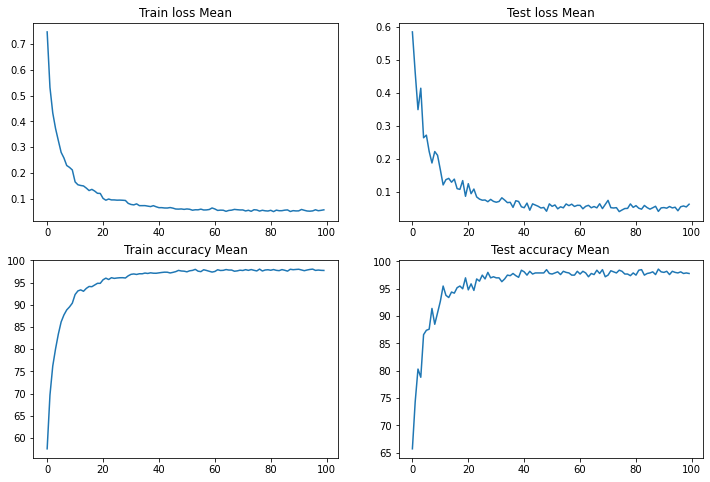

In [10]:
figure = plt.figure(figsize=(12, 8))
cols, rows = 2, 2
figure.add_subplot(rows, cols, 1)
plt.title('Train loss Mean')
plt.plot(all_train_loss_mean)
figure.add_subplot(rows, cols, 2)
plt.title('Test loss Mean')
plt.plot(all_test_loss_mean)
figure.add_subplot(rows, cols, 3)
plt.title('Train accuracy Mean')
plt.plot(all_train_accuracy)
figure.add_subplot(rows, cols, 4)
plt.title('Test accuracy Mean')
plt.plot(all_test_accuracy)

# Testing

In [11]:
true_label, pred_label, pred_score, one_hot = [], [], [], []
with torch.no_grad():
    model.eval()
    for i, (x, y) in enumerate(tqdm(lense_test)):
        x = x.to(device)
        y = y.to(device)
        _y = model(x)

        _, pred = torch.max(_y.data, 1)
        true_label += y.tolist()
        pred_label += pred.tolist()
        pred_score += _y.tolist()
        one_hot += np.eye(3)[y.cpu().numpy()].tolist()

100%|██████████| 16/16 [00:01<00:00, 13.02it/s]


# Confusion Matrix

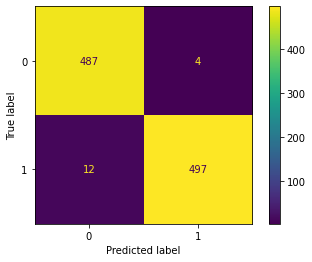

In [12]:
ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix(true_label, pred_label)
).plot()

# AUC-SCORE

In [13]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

In [14]:
roc_auc_score(np.array(true_label),np.array(pred_label))

0.9841388609909609

# ROC Curve

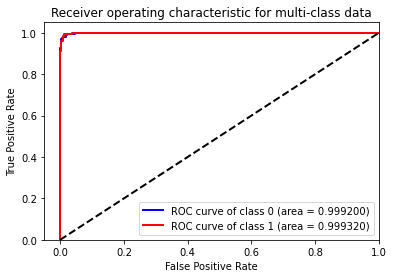

In [15]:
fpr = dict()
tpr = dict()
roc_auc = dict()
lw=2
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(np.array(one_hot)[:, i], np.array(pred_score)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(2), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.6f})'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()